# Coronavirus Sentiment Analysis

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import string
import nltk
# if you have never done so, you need to download stopwords from nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
import re
import itertools
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

from nltk.sentiment.util import mark_negation
from nltk import word_tokenize

In [2]:
#load data
data = pd.read_csv("coronavirus_tweets.csv", encoding="ISO-8859-1")

In [3]:
#check data to see if everything worked
data.head(10)

,Comments,Date,Favorites,User,Polarity,Sentiment
0,RT @brianschatz: Trumpâs Coronavirus Press E...,2020-03-08 01:22:39,0,Dwight Evans,-0.400000,negative
1,RT @SkyNews: Coronavirus: Hotel used for quara...,2020-03-08 01:22:39,0,ð·Libertyð·,0.000000,neutral
2,RT @DrDenaGrayson: Lung inflammation + low lym...,2020-03-08 01:22:39,0,leone5464,0.000000,neutral
3,"RT @richardhine: ""Pretending we could wall out...",2020-03-08 01:22:39,0,Bruce MacNeil,-0.100000,negative
4,RT @Talya8news: BREAKING-- Virginia confirms f...,2020-03-08 01:22:39,0,Bobby Hutton,0.250000,positive
5,RT @scottwongDC: BREAKING: Attendees of both t...,2020-03-08 01:22:39,0,Kim,0.000000,neutral
6,RT @washingtonpost: Squandered time: How the T...,2020-03-08 01:22:39,0,gmcustodio,0.000000,neutral
7,RT @RedPillMaC: China has armed #COVID epidem...,2020-03-08 01:22:39,0,David E. Lentz,0.187143,positive
8,RT @RichardHaass: Truly sobering analysis: US ...,2020-03-08 01:22:39,0,John Robert Kraai,0.165000,positive
9,Gonna drink enough alcohol to kill the coronav...,2020-03-08 01:22:39,0,register to vote,0.000000,neutral


neutral     2606
positive    1641
negative     753
Name: Sentiment, dtype: int64

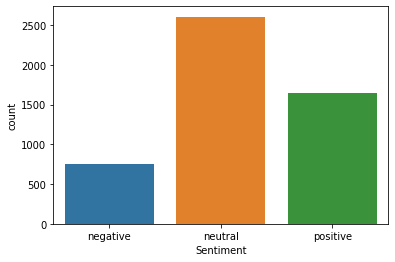

In [4]:
## What do we have for sentiment breakdown?
sns.countplot(x = 'Sentiment', data = data)
data['Sentiment'].value_counts()

In [5]:
## What are these negative comments?

#format columns so comments don't get cut off
pd.set_option('display.max_columns', None) 

#pull negative comments
data.loc[data['Sentiment'] == 'negative']['Comments'].unique()[0:1]

array(['RT @brianschatz: Trumpâ\x80\x99s Coronavirus Press Event Was Even Worse Than It Looked | WIRED https://t.co/p4d8DnmbhU'],
      dtype=object)

In [6]:
# A) Create a set of test (20% of data) and training (80% of data) data
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
# Be sure to check the length of the training and test sets to confirm data was split in the correct porportions
print(len(train), len(test))
print("Split of {:.2%} train, {:.2%} test".format(len(train)/len(data), len(test)/len(data)))

4000 1000
Split of 80.00% train, 20.00% test


In [8]:
# B) Lemmatize words, and remove stop words and punctuation
lemmatizer = WordNetLemmatizer()

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove URLs
    2. Remove punctuation
    3. Remove numbers
    4. Remove stopwords
    5. Return the cleaned text as a list of lemmatized words
    '''
    
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text, flags=re.MULTILINE)
    
    text = ''.join([t for t in text if t not in string.punctuation])
    
    text = ''.join([t for t in text if not t.isdigit()])
    
    return [lemmatizer.lemmatize(word) for word in text.split() if word.lower() not in stopwords.words('english')]

In [9]:
# C) Represent the text in a bag-of-words by leveraging CountVectorization in the sklearn library.
vectorizer = CountVectorizer(analyzer=text_process)
train_features = vectorizer.fit_transform(train['Comments'])
test_features =  vectorizer.transform(test['Comments'])

In [10]:
vectorizer.get_feature_names()[0:10]

['AAD',
 'AAPInNews',
 'ABC',
 'ABCBrandi',
 'ABCNews',
 'ABDâ\x80\x99de',
 'ABSCBNNews',
 'ACC',
 'ACOM',
 'ACT']

In [11]:
# Test the vectorizer by looking at the size of the vectors and snippets of the vectors
print('Length of Vectorizer Vocabulary: ', len(vectorizer.vocabulary_))
print('Shape of Sparse Matrix: ', test_features.shape)
print('Amount of Non-Zero occurrences: ', test_features.nnz)

# Percentage of non-zero values
density = 100.0 * (test_features.nnz / (test_features.shape[0] * test_features.shape[1]))
print('Density: {}'.format((density)))

Length of Vectorizer Vocabulary:  12173
Shape of Sparse Matrix:  (1000, 12173)
Amount of Non-Zero occurrences:  11989
Density: 0.09848845806292615


In [12]:
# To understand how the vectorizer stores words, we will input a sample test data review
sample_test = test['Comments'].iloc[0]
print("Sample comment: ", sample_test, "\n")
sample_vector = vectorizer.transform([sample_test])
print("Vectorization:")
print(sample_vector)

Sample comment:  RT @MSNBC: "The most egregious level of incompetence in an admin. that I think we've witnessed ... absolute gross, amateur hour incompetencâ¦ 

Vectorization:
  (0, 2287)	1
  (0, 3121)	1
  (0, 4197)	1
  (0, 4273)	1
  (0, 4431)	1
  (0, 6239)	1
  (0, 7010)	1
  (0, 7254)	1
  (0, 7392)	1
  (0, 7393)	1
  (0, 7840)	1
  (0, 10669)	1
  (0, 11268)	1
  (0, 11310)	1


(-0.5, 1599.5, 1199.5, -0.5)

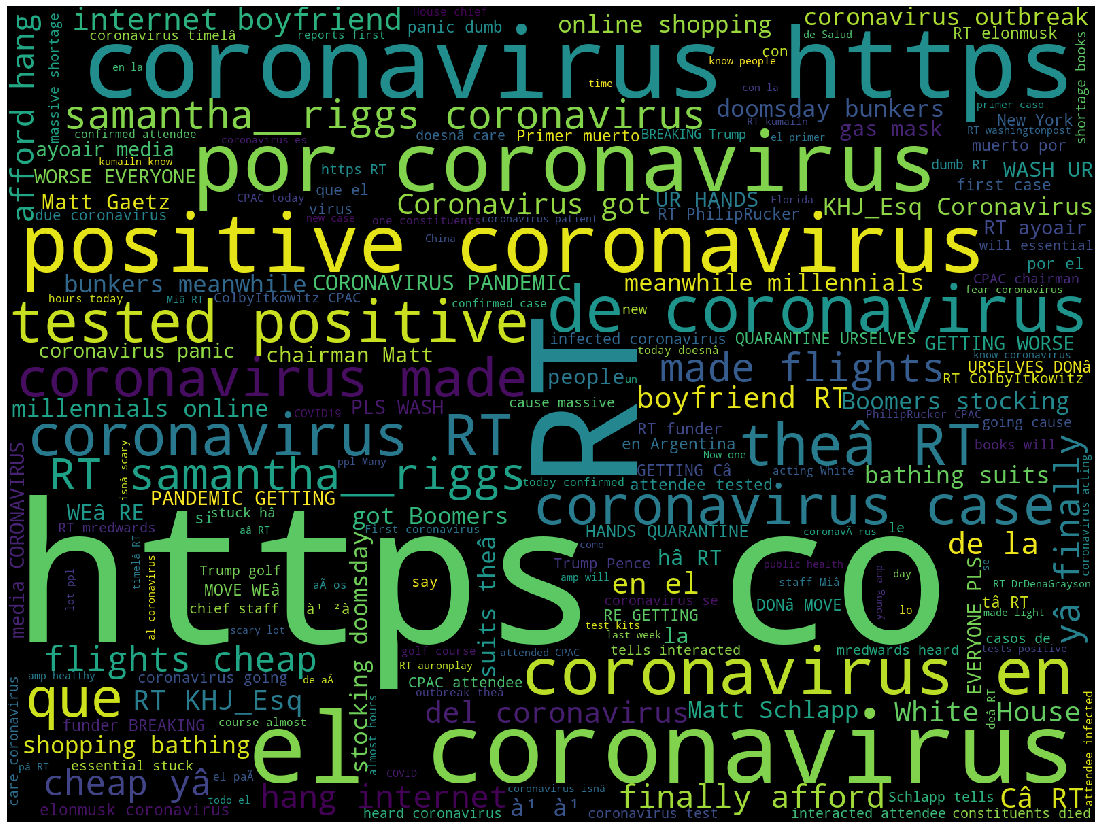

In [13]:
cloud = WordCloud(width=1600, height=1200).generate(" ".join(data['Comments'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# Naive Bayes

In [14]:
#train your data set using multinomial NB from sklearn library
nb = MultinomialNB()
nb.fit(train_features, train['Sentiment'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
#test your data set on your test data
preds_nb = nb.predict(test_features)

#print the accuracy of your model
accuracy_NB = (preds_nb == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy_NB.sum() / len(accuracy_NB))

'Accuracy : 85.40%'

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[106   6  36]
 [ 10 429  75]
 [  7  12 319]]
Normalized confusion matrix
[[0.71621622 0.04054054 0.24324324]
 [0.01945525 0.83463035 0.1459144 ]
 [0.02071006 0.03550296 0.94378698]]


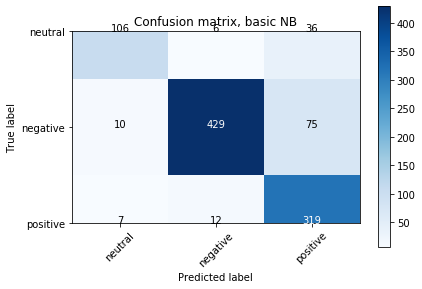

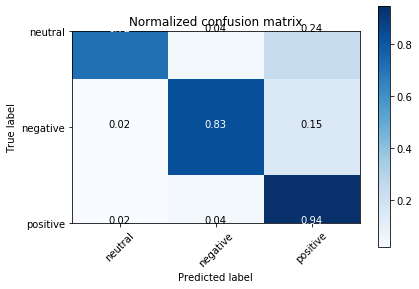

In [17]:
class_names = set(data['Sentiment'])
cnf_matrix = confusion_matrix(test['Sentiment'], preds_nb)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, basic NB')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Logistic Regression

In [18]:
# primero importamos la libreria de Regresion Logistica de SkLearn
from sklearn.linear_model import LogisticRegression
log_rg = LogisticRegression()
log_rg.fit(train_features, train['Sentiment'])


#test your data set on your test data
preds_lr = log_rg.predict(test_features)

#print the accuracy of your model
accuracy_lr = (preds_lr == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy_lr.sum() / len(accuracy_lr))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


'Accuracy : 88.90%'

Confusion matrix, without normalization
[[104  31  13]
 [  3 497  14]
 [  6  44 288]]
Normalized confusion matrix
[[0.7027027  0.20945946 0.08783784]
 [0.00583658 0.96692607 0.02723735]
 [0.01775148 0.13017751 0.85207101]]


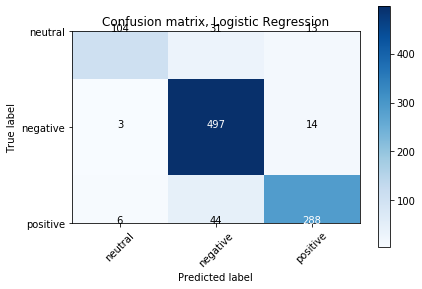

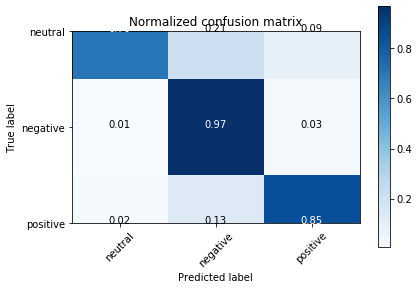

In [19]:
class_names_LR = set(data['Sentiment'])
cnf_matrix_LR = confusion_matrix(test['Sentiment'], preds_lr)
plt.figure()
plot_confusion_matrix(cnf_matrix_LR, classes=class_names,
                      title='Confusion matrix, Logistic Regression')

plt.figure()
plot_confusion_matrix(cnf_matrix_LR, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [20]:
from sklearn.ensemble import RandomForestClassifier
randm_frst = RandomForestClassifier()
randm_frst.fit(train_features, train['Sentiment'])

#test your data set on your test data
preds_rf = randm_frst.predict(test_features)

#print the accuracy of your model
accuracy_rf = (preds_rf == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy_rf.sum() / len(accuracy_rf))

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


'Accuracy : 89.20%'

Confusion matrix, without normalization
[[104  35   9]
 [  2 510   2]
 [  6  54 278]]
Normalized confusion matrix
[[0.7027027  0.23648649 0.06081081]
 [0.00389105 0.9922179  0.00389105]
 [0.01775148 0.15976331 0.82248521]]


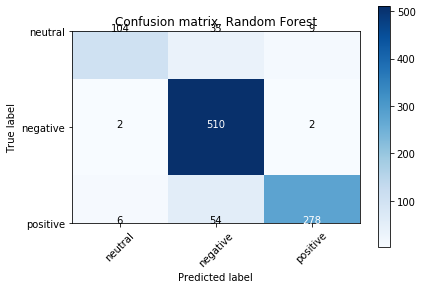

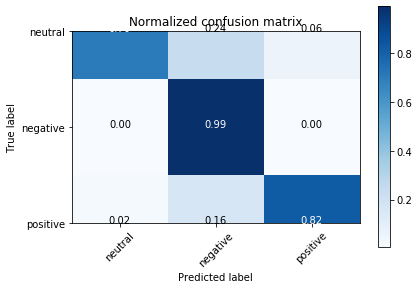

In [21]:
class_names_RF = set(data['Sentiment'])
cnf_matrix_RF = confusion_matrix(test['Sentiment'], preds_rf)
plt.figure()
plot_confusion_matrix(cnf_matrix_RF, classes=class_names,
                      title='Confusion matrix, Random Forest')

plt.figure()
plot_confusion_matrix(cnf_matrix_RF, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# SVM

In [22]:
from sklearn import svm
clf_SVM = svm.SVC(kernel='linear')  
clf_SVM.fit(train_features, train['Sentiment'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [23]:
y_train = clf_SVM.predict(train_features)  

In [25]:
from sklearn.metrics import classification_report
print(confusion_matrix(train['Sentiment'],y_train)) 
print(classification_report(train['Sentiment'],y_train))  

[[ 605    0    0]
 [   0 2092    0]
 [   0    0 1303]]
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       605
     neutral       1.00      1.00      1.00      2092
    positive       1.00      1.00      1.00      1303

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



In [26]:
y_pred = clf_SVM.predict(test_features)  

In [27]:
print(confusion_matrix(test['Sentiment'],y_pred)) 
print(classification_report(test['Sentiment'],y_pred)) 

[[111  24  13]
 [  3 499  12]
 [ 11  44 283]]
              precision    recall  f1-score   support

    negative       0.89      0.75      0.81       148
     neutral       0.88      0.97      0.92       514
    positive       0.92      0.84      0.88       338

    accuracy                           0.89      1000
   macro avg       0.90      0.85      0.87      1000
weighted avg       0.89      0.89      0.89      1000



In [31]:
#print the accuracy of your model
accuracy_svm = (y_pred == test['Sentiment'])
'Accuracy : {:.2%}'.format(accuracy_svm.sum() / len(accuracy_svm))

'Accuracy : 89.30%'

# Compare Results

In [37]:
LR_acc = '{:.2%}'.format(accuracy_lr.sum() / len(accuracy_lr))
NB_acc = '{:.2%}'.format(accuracy_NB.sum() / len(accuracy_NB))
RF_acc = '{:.2%}'.format(accuracy_rf.sum() / len(accuracy_rf))
SVM_acc = '{:.2%}'.format(accuracy_svm.sum() / len(accuracy_svm))

In [38]:
from pandas import DataFrame
scores = {'Model':  ['Linear Regression','Naive_Bayes', 'Random Forest', 'SVM'], 
          'Accuracy': [LR_acc,NB_acc,RF_acc,SVM_acc]}
acc_scores = DataFrame (scores, columns = ['Model','Accuracy'])
acc_scores

,Model,Accuracy
0,Linear Regression,88.90%
1,Naive_Bayes,85.40%
2,Random Forest,89.20%
3,SVM,89.30%


# Tunning

In [40]:
from sklearn.model_selection import GridSearchCV
param_frst = [{"n_estimators": [10,100,200,300,500], "criterion": ["gini", "entropy"]}]
grid_search_frst = GridSearchCV(estimator=randm_frst,
                          param_grid=param_frst,
                          scoring = 'accuracy',
                          cv=5)
grid_search_frst = grid_search_frst.fit(train_features, train['Sentiment'])

In [41]:
# Calcular accuracy para Random Forest 
best_acc_frst = grid_search_frst.best_score_
best_acc_frst

0.86875